# Model fitting and Optimization

In this lesson, we introduce regression and Gaussian process. By the
end of the lesson, we will be able to:

- Understand the objectives and components of regression.
- Understand (stochastic) gradient descent as an optimization algorithm.

This tutorial is modified from
- Zhang *et al.*'s tutorial on Linear Regression, Gradient Descent, Stochastic Gradient Descent, and Gaussian Processes at [Dive into Deep Learning](http://d2l.ai/chapter_gaussian-processes/gp-intro.html)


## Regression

**Purpose**: to predict a continuous value based on observation data, i.e., stock price, temperature, and (even) GPA of a class.

**Components**:
- **data**: the observation
- **model**: a mathematical function with unknown parameters
- **loss function**: the criterion for determining if our model is optimal
- **optimization algorithm**: the method we use to determine the parameters in the model from the data


### A simple example - linear regression

In the `scikit-learn` library, `LinearRegression` fits a _linear model_ $$\hat{f}(w, x) = w_1 x_1 + ... + w_p x_p + b
$$ with coefficients $w = (w_1, ..., w_p)$ and bias $b$ to minimize the residual sum
of squares between the observed targets in the dataset, and the
targets predicted by the linear approximation. Mathematically it
solves a problem of the form:$$\min_{w} L(X,f(X)),$$ where $L(X,f(X))=|| X w - f(X)||_2^2$ is the loss function. Note that $X=(x_1, ..., x_p)$ is a vector while $f(X)$ is a number.

Let's look at its application. **First**, we import the libraries needed and load some sample data.

In [1]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

**Then**, we build the model `regr` and train it. For linear regression, we try to minimize the mean square error as defined above. Note that because the optimal coefficients $w$ can be derived analytically. We do not need an optimization algorithm in this case. (Unfortunately, in most cases this is impossible, and 99% of the time we still need an optimization algorithm)

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


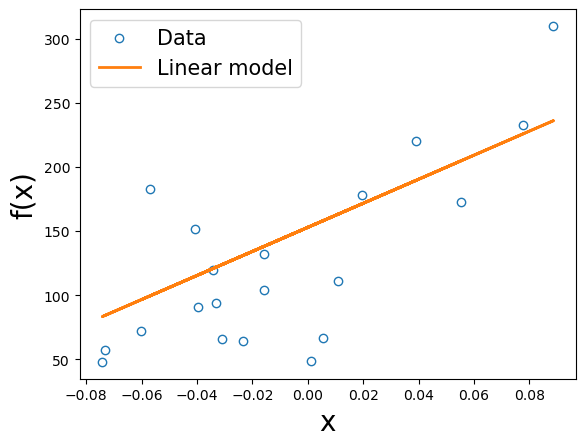

In [2]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,label="Data",edgecolor="C0",facecolor="w")
plt.plot(diabetes_X_test, diabetes_y_pred,linewidth=2,label="Linear model",color="C1")
plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.legend(fontsize = 15)
plt.show()

### Optimization 

**Goal**: Once we have obtained the data and selected an appropriate model (including a loss function). We need to perform the following operation:
$$\min_{w} L(X,f(X))$$

Optimization is the process when the machine _learns_ from the data. As always, learning is not easy!

**Challenge 1: Local minima**

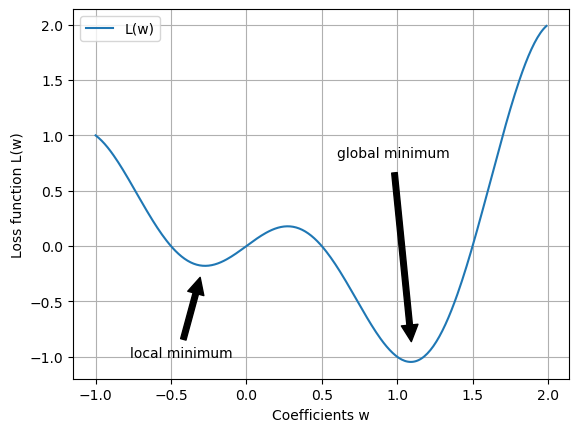

In [3]:
# Define the function f(x)
def f(x):
    return x * np.cos(np.pi * x)
    
# Generate x values
x = np.arange(-1.0, 2.0, 0.01)

# Calculate f(x) values
fx = f(x)

# Plot the function
plt.plot(x, fx, label='L(w)')
plt.xlabel('Coefficients w')
plt.ylabel('Loss function L(w)')
# plt.title('Function f(x)')
plt.grid(True)

# Annotate the plot
plt.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.show()


**Challenge 2: Saddle point**

A *saddle point* is any location where all gradients of a function vanish but which is neither a global nor a local minimum. 

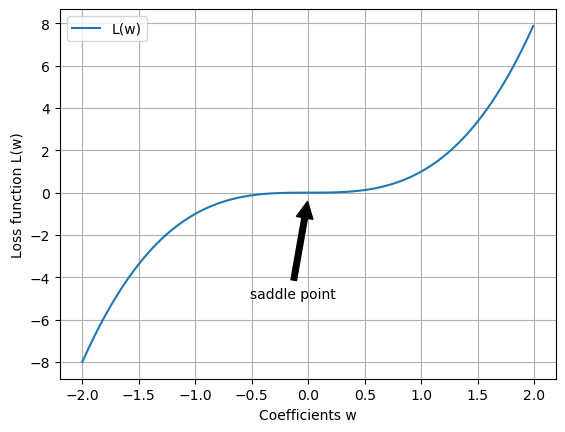

In [4]:
# Generate x values
x = np.arange(-2.0, 2.0, 0.01)

# Calculate f(x) values
fx = x**3

# Plot the function
plt.plot(x, fx, label='L(w)')
plt.xlabel('Coefficients w')
plt.ylabel('Loss function L(w)')
# plt.title('Function f(x)')
plt.grid(True)

# Annotate the plot
plt.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.show()


**Challenge 3: Vanishing gradient**


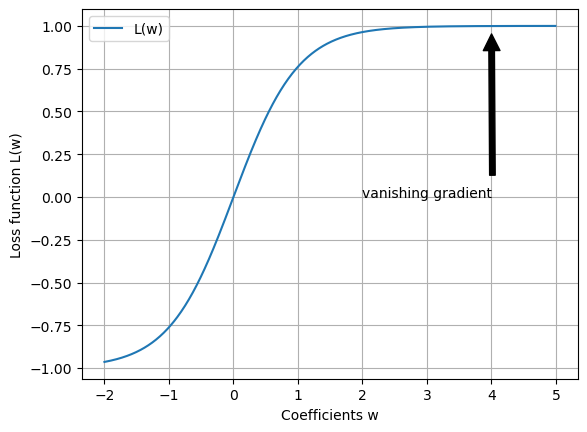

In [5]:
# Generate x values
x = np.arange(-2.0, 5.0, 0.01)

# Calculate tanh function values
tanh_x = np.tanh(x)

# Plot the function
plt.plot(x, tanh_x, label='L(w)')
plt.xlabel('Coefficients w')
plt.ylabel('Loss function L(w)')
# plt.title('Tanh Function')
plt.grid(True)

# Annotate the plot
plt.annotate('vanishing gradient', xy=(4, 1), xytext=(2, 0.0),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.show()


**Summary on optimization (learning)**
    
- Minimizing the training error does not guarantee that we find the best set of parameters to minimize the generalization error.
- The optimization problems may have many local minima.
- The problem may have even more saddle points, as generally the problems are not convex.
- Vanishing gradients can cause optimization to stall. Often a reparametrization of the problem helps. Good initialization of the parameters can be beneficial, too.


## An example optimization algorithm: Gradient Descent

Gradient descent is an optimization algorithm that may reduce the value of the objective function. Consider some continuously differentiable 1D real-valued function $f(x)$. Using a Taylor expansion we obtain
$$f(x + \epsilon) = f(x) + \epsilon f'(x).$$

In first-order approximation, $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. 

We find that $f(x+\epsilon)<f(x)$ if $\epsilon$ and $f'(x)$ have opposite signs. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x).$$

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher-order terms to become irrelevant. 

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. 

Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes.

In [6]:
def f(x):
    if isinstance(x, list):
        return [xi**2 for xi in x]  # Apply the operation element-wise if x is a list
    else:
        return x**2  # Otherwise, if x is a single value, perform the operation directly


def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.

In [7]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


The progress of optimizing over x can be plotted as follows.

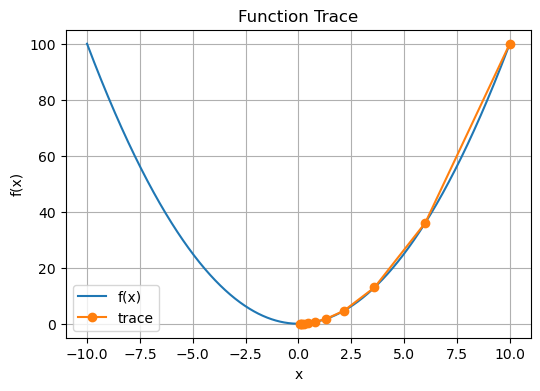

In [8]:
def show_trace(results, f):
    n = max(abs(np.min(results)), abs(np.max(results)))
    f_line = np.arange(-n, n, 0.01)
    plt.figure(figsize=(6, 4))
    plt.plot(f_line, f(f_line), '-', label='f(x)')
    plt.plot(results, f(results), '-o', label='trace')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Function Trace')
    plt.legend()
    plt.grid(True)
    plt.show()

show_trace(results, f)

### Learning Rate $\eta$
The step size $\eta$ is also called the *learning rate*. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.


epoch 10, x: 3.486784


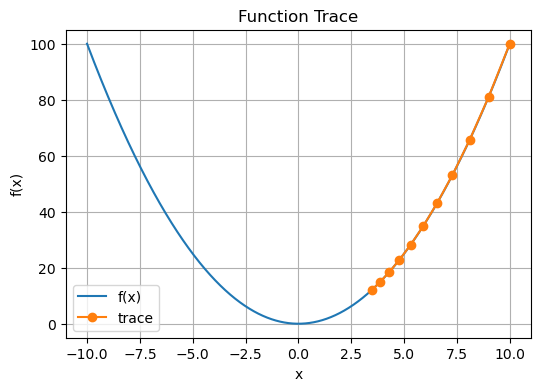

In [9]:
show_trace(gd(0.05, f_grad), f)

### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


epoch 10, x: -1.528166


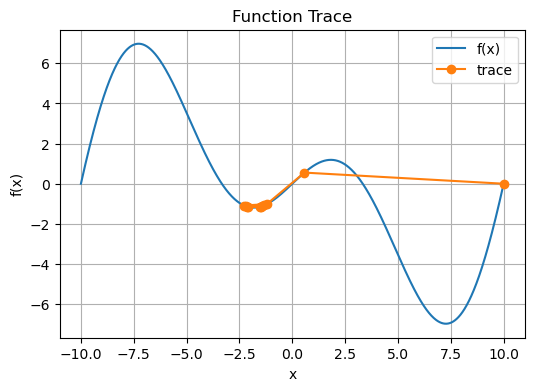

In [10]:
def f(x):  # Objective function
    c = 0.15 * np.pi
    if isinstance(x, list):
        return [xi * np.cos(c * xi) for xi in x]  # Apply the operation element-wise if x is a list
    else:
        return x * np.cos(c * x)  # Otherwise, if x is a single value, perform the operation directly

def f_grad(x):  # Gradient of the objective function
    c = 0.15 * np.pi
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2, f_grad), f)

## Multivariate Gradient Descent

We now generalize the algorithm and consider a multivariate case where $\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$. That is, the objective function $f(\mathbf{x})$ maps vectors into scalars. Correspondingly its gradient is multivariate, too. It is a vector consisting of $d$ partial derivatives:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Each partial derivative element $\partial f(\mathbf{x})/\partial x_i$ in the gradient indicates the rate of change of $f$ at $\mathbf{x}$ with respect to the input $x_i$. 

Similarly, let's do a Taylor expansion, accurate up to the first order

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}).$$

(Note that $\boldsymbol{\epsilon} = [\epsilon_1, \epsilon_2, \ldots, \epsilon_d]^\top$ is also a vector, and $\mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x})=\frac{\epsilon_1\partial f(\mathbf{x})}{\partial x_1}, \epsilon_2\frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \epsilon_d\frac{\partial f(\mathbf{x})}{\partial x_d}$

Therefore, we can always ensure $f(\mathbf{x} + \boldsymbol{\epsilon})<f(x)$ if $\boldsymbol{\epsilon}$ is proportional to the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

To see how the algorithm behaves in practice let's consider the following exammple:
- An objective function $f(\mathbf{x})=x_1^2+2x_2^2$
- Two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input
- A scalar as output
- The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$.

We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$. We define an update function `train_2d` that applies the gradient descent algorithm 20 times to the initial value, and a second function `show_trace_2d` that visualizes the trajectory of $\mathbf{x}$.


epoch 20, x1: -0.057646075230342354, x2: -7.312316880125945e-05


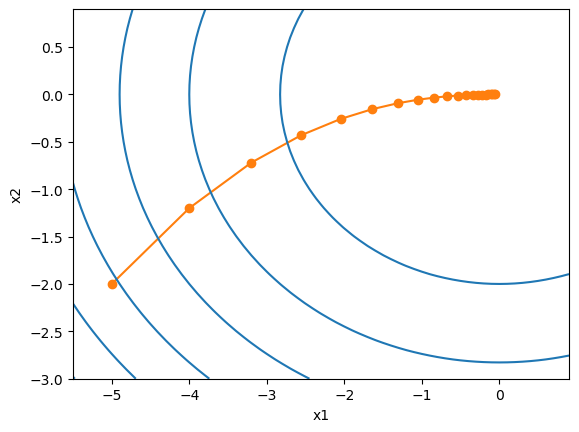

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train_2d(trainer, steps=20, f_grad=None):
    # Initialize variables
    x = np.array([-5, -2])
    results = [x.copy()]
    for i in range(steps):
        if f_grad:
            grad = f_grad(*x)
            x = trainer(x, grad)
        else:
            x = trainer(x)
        results.append(x.copy())
    print(f'epoch {i + 1}, x1: {x[0]}, x2: {x[1]}')
    return results

def show_trace_2d(f, results):
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1), indexing='ij')
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

def f_2d(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):
    return np.array([2 * x1, 4 * x2])

def gd_2d(x, grad):
    return x - eta * grad
    

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))



Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.



## Stochastic Gradient Updates

In many cases, the objective function is usually the average of the loss functions for each example in the training dataset. Suppose we have a training dataset of $n$ examples, and $f_i(\mathbf{x})$ is the loss function with respect to the training example of index $i$. Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. Instead of calculating all $n$ gradient, at each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. 

Notice that

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient $\nabla f_i(\mathbf{x})$ is a good estimate of the full gradient $\nabla f(\mathbf{x})$.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


epoch 50, x1: 0.18789296550151324, x2: -0.3002167592528058


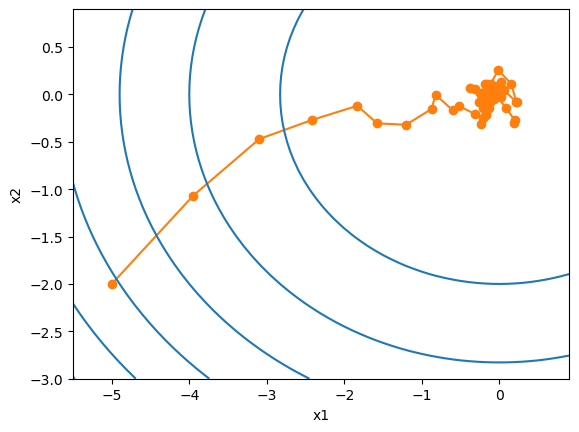

In [12]:
def sgd(x, grad):
    g1, g2 = grad
    # Simulate noisy gradient
    g1 += np.random.normal(0.0, 1)
    g2 += np.random.normal(0.0, 1)
    eta_t = eta * lr()
    return x - eta_t * np.array([g1, g2])

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
results = train_2d(sgd, steps=50, f_grad=f_2d_grad)
show_trace_2d(f_2d, results)

As we can see, the trajectory of the variables in the stochastic gradient descent is much more noisy than the one we observed in gradient descent. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage you to experiment with a larger number of steps to confirm this). This leaves us with the only alternative: change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

**Summary on gradient descent**

- Learning rates matter. Too large and we diverge, too small and we do not make progress.
- Gradient descent can get stuck in local minima.
- In high dimensions adjusting the learning rate is complicated.

